In [13]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [2]:
def get_target_label_idx(labels, targets, shots=5, test=False):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    final_list = []
    
    for t in targets:
        if test:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()
        else:
            final_list += np.argwhere(np.isin(labels, t)).flatten().tolist()[:shots]
    
    return final_list

In [3]:
# function to convert labels [5,6,7,8,9] to [0,1,2,3,4]
def convert_label(x):

    if x >= 5:
        return x-5
    else:
        return x

In [4]:
from torch.utils.data import Subset
from PIL import Image
from torchvision.datasets import MNIST

import torchvision.transforms as transforms

class MNIST_Dataset(Dataset):

    def __init__(self, root: str, normal_class=[5,6,7,8,9], shots=5):
        super().__init__()

        self.root = root
        self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = tuple(normal_class)
        self.outlier_classes = list(range(0, 10))
        self.outlier_classes = [item for item in self.outlier_classes if item not in self.normal_classes]
#         self.outlier_classes.remove(normal_class)
        print("classes: ", self.normal_classes)
#         # MNIST preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        transform = transforms.Compose([transforms.ToTensor()])

#         target_transform = transforms.Lambda(lambda x: int(x in self.normal_classes))
        
        target_transform = transforms.Lambda(lambda x: convert_label(x))
        train_set = MyMNIST(root=self.root, train=True, download=True,
                            transform=transform, target_transform=target_transform)
        # Subset train_set to normal class
        train_idx_normal = get_target_label_idx(train_set.train_labels.clone().data.cpu().numpy(), self.normal_classes, shots=shots)
        self.train_set = Subset(train_set, train_idx_normal)

        test_set = MyMNIST(root=self.root, train=False, download=True,
                                transform=transform, target_transform=target_transform)
        
        test_idx_normal = get_target_label_idx(test_set.test_labels.clone().data.cpu().numpy(), self.normal_classes, test=True)
        self.test_set = Subset(test_set, test_idx_normal)

    

        
        

class MyMNIST(MNIST):
    """Torchvision MNIST class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyMNIST, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the MNIST class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed



In [5]:
""" LeNet architecture implementation
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 5)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in train_loader:
                    inputs, labels, idx = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
            else:
                
                model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in test_loader:
                    inputs, labels, idx = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        loss = criterion(outputs, labels)
                
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / test_size
                epoch_acc = running_corrects.double() / test_size
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

classes:  (5, 6, 7, 8, 9)
Labels:  tensor([4, 3, 4, 0, 1])


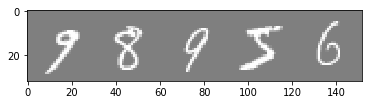

In [8]:
mninst_dataset = MNIST_Dataset(root='data/', shots=5)
train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels, idx = dataiter.next()
print("Labels: ", labels)

# show images
imshow(torchvision.utils.make_grid(images))
    

# Section 2: Training Models

# 2.1 Plain LeNet Model

In [14]:
shot_list = [5, 10, 15, 20, 25, 30] # no of images per class 
n_epochs = 20
best_net_dict = {}
best_acc_list = []
for shot in shot_list:
    
    mninst_dataset = MNIST_Dataset(root='data/', normal_class=[0,1,2,3,4], shots=shot)
    train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)
    test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
    train_size =  len(mninst_dataset.train_set)
    test_size = len(mninst_dataset.test_set)
    
    net = LeNet().to(device)
# loading pretrained model
#     net = torch.load('LeNet_5_class_pretrained_model.tar')
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=n_epochs)
    
    best_acc_list.append(best_acc.item())
    best_net_dict.update({shot : best_net})

classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 1.6173 Acc: 0.1200
Val Loss: 1.6090 Acc: 0.1911

Epoch 1/19
----------
Train Loss: 1.6004 Acc: 0.2800
Val Loss: 1.5987 Acc: 0.3586

Epoch 2/19
----------
Train Loss: 1.5847 Acc: 0.4400
Val Loss: 1.5827 Acc: 0.4299

Epoch 3/19
----------
Train Loss: 1.5639 Acc: 0.4000
Val Loss: 1.5582 Acc: 0.4514

Epoch 4/19
----------
Train Loss: 1.5186 Acc: 0.6000
Val Loss: 1.5159 Acc: 0.5328

Epoch 5/19
----------
Train Loss: 1.4520 Acc: 0.6000
Val Loss: 1.4393 Acc: 0.6258

Epoch 6/19
----------
Train Loss: 1.3341 Acc: 0.7600
Val Loss: 1.3194 Acc: 0.7618

Epoch 7/19
----------
Train Loss: 1.2118 Acc: 0.9200
Val Loss: 1.3032 Acc: 0.7990

Epoch 8/19
----------
Train Loss: 1.1902 Acc: 1.0000
Val Loss: 1.2850 Acc: 0.8282

Epoch 9/19
----------
Train Loss: 1.1668 Acc: 1.0000
Val Loss: 1.2657 Acc: 0.8385

Epoch 10/19
----------
Train Loss: 1.1424 Acc: 1.0000
Val Loss: 1.2478 Acc: 0.8404

Epoch 11/19
----------
Train Loss: 1.1209 Acc: 1.0000
Val Lo

Val Loss: 0.1628 Acc: 0.9496

Epoch 15/19
----------
Train Loss: 0.0313 Acc: 0.9920
Val Loss: 0.1628 Acc: 0.9498

Epoch 16/19
----------
Train Loss: 0.0312 Acc: 0.9920
Val Loss: 0.1627 Acc: 0.9496

Epoch 17/19
----------
Train Loss: 0.0308 Acc: 0.9920
Val Loss: 0.1626 Acc: 0.9498

Epoch 18/19
----------
Train Loss: 0.0307 Acc: 0.9920
Val Loss: 0.1623 Acc: 0.9494

Epoch 19/19
----------
Train Loss: 0.0305 Acc: 0.9920
Val Loss: 0.1623 Acc: 0.9494

Training complete in 0m 13s
Best val Acc: 0.949796
classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 1.5656 Acc: 0.3733
Val Loss: 1.3679 Acc: 0.5713

Epoch 1/19
----------
Train Loss: 0.9112 Acc: 0.7400
Val Loss: 0.4548 Acc: 0.8708

Epoch 2/19
----------
Train Loss: 0.3652 Acc: 0.8867
Val Loss: 0.3479 Acc: 0.8597

Epoch 3/19
----------
Train Loss: 0.1665 Acc: 0.9400
Val Loss: 0.1708 Acc: 0.9451

Epoch 4/19
----------
Train Loss: 0.1740 Acc: 0.9333
Val Loss: 0.2104 Acc: 0.9303

Epoch 5/19
----------
Train Loss: 0.1637 Acc: 0.9400
Val L

# Summary: Accuracy on Plain LeNet Model

In [15]:
# print("Pretrained model Acc: 0.916067")
print("5 way N shots classification accuracy using LeNet")
best_acc_df = pd.DataFrame({'# images per class' : shot_list,
                            'Accuracy' : best_acc_list})
best_acc_df

5 way N shots classification accuracy using LeNet


,# images per class,Accuracy
0,5,0.856587
1,10,0.929558
2,15,0.927612
3,20,0.950574
4,25,0.949796
5,30,0.964779


# 2.2 Using Pretrained Model

Pretraining LeNet using (5,6,7,8,9) classes images and use them to predict for (0,1,2,3,4) classes in different shots

# Pretraining Model

In [16]:
# pretraining model
mninst_dataset = MNIST_Dataset(root='data/', normal_class=[5,6,7,8,9] ,shots=1000)
train_loader = DataLoader(mninst_dataset.train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
train_size =  len(mninst_dataset.train_set)
test_size = len(mninst_dataset.test_set)

net = LeNet().to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

classes:  (5, 6, 7, 8, 9)
Epoch 0/99
----------
Train Loss: 0.7339 Acc: 0.7534
Val Loss: 0.2500 Acc: 0.9241

Epoch 1/99
----------
Train Loss: 0.1984 Acc: 0.9338
Val Loss: 0.1583 Acc: 0.9467

Epoch 2/99
----------
Train Loss: 0.1264 Acc: 0.9582
Val Loss: 0.1157 Acc: 0.9630

Epoch 3/99
----------
Train Loss: 0.0918 Acc: 0.9710
Val Loss: 0.1016 Acc: 0.9671

Epoch 4/99
----------
Train Loss: 0.0698 Acc: 0.9780
Val Loss: 0.0703 Acc: 0.9776

Epoch 5/99
----------
Train Loss: 0.0562 Acc: 0.9830
Val Loss: 0.0557 Acc: 0.9817

Epoch 6/99
----------
Train Loss: 0.0466 Acc: 0.9866
Val Loss: 0.0588 Acc: 0.9803

Epoch 7/99
----------
Train Loss: 0.0381 Acc: 0.9876
Val Loss: 0.0485 Acc: 0.9842

Epoch 8/99
----------
Train Loss: 0.0359 Acc: 0.9890
Val Loss: 0.0475 Acc: 0.9819

Epoch 9/99
----------
Train Loss: 0.0335 Acc: 0.9900
Val Loss: 0.0482 Acc: 0.9831

Epoch 10/99
----------
Train Loss: 0.0258 Acc: 0.9914
Val Loss: 0.0543 Acc: 0.9819

Epoch 11/99
----------
Train Loss: 0.0213 Acc: 0.9934
Val Lo

Val Loss: 0.0383 Acc: 0.9897

Epoch 98/99
----------
Train Loss: 0.0026 Acc: 0.9998
Val Loss: 0.0383 Acc: 0.9897

Epoch 99/99
----------
Train Loss: 0.0026 Acc: 0.9998
Val Loss: 0.0383 Acc: 0.9897

Training complete in 2m 26s
Best val Acc: 0.989714


In [17]:
# Saving the pretrained model
pretrained_model_acc = best_acc.item()
torch.save(best_net, 'LeNet_5_class_pretrained_model.tar')
print("Pretrained Model Validation Accuracy: ", pretrained_model_acc)

Pretrained Model Validation Accuracy:  0.989714050606871


/home/haal01/home/haal01/env_svdd/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Few shot learing in Pretrained Model

In [18]:
shot_list = [5, 10, 15, 20, 25, 30] # no of images per class 
n_epochs = 20
pretrained_best_net_dict = {}
pretrained_best_acc_list = []
for shot in shot_list:
    
    mninst_dataset = MNIST_Dataset(root='data/', normal_class=[0,1,2,3,4], shots=shot)
    train_loader = DataLoader(mninst_dataset.train_set, batch_size=5, shuffle=True, num_workers=0)
    test_loader = DataLoader(mninst_dataset.test_set, batch_size=200, shuffle=True, num_workers=0)
    train_size =  len(mninst_dataset.train_set)
    test_size = len(mninst_dataset.test_set)
    
    
# loading pretrained model
    net = torch.load('LeNet_5_class_pretrained_model.tar')
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(net.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    best_net, best_acc = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=n_epochs)
    
    pretrained_best_acc_list.append(best_acc.item())
    pretrained_best_net_dict.update({shot : best_net})

classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 4.5496 Acc: 0.4000
Val Loss: 3.0084 Acc: 0.4435

Epoch 1/19
----------
Train Loss: 1.9423 Acc: 0.6000
Val Loss: 1.9751 Acc: 0.5629

Epoch 2/19
----------
Train Loss: 0.8889 Acc: 0.8400
Val Loss: 1.2524 Acc: 0.6737

Epoch 3/19
----------
Train Loss: 0.3208 Acc: 0.9200
Val Loss: 0.8926 Acc: 0.7655

Epoch 4/19
----------
Train Loss: 0.0585 Acc: 1.0000
Val Loss: 0.7775 Acc: 0.7918

Epoch 5/19
----------
Train Loss: 0.0346 Acc: 1.0000
Val Loss: 0.7306 Acc: 0.7996

Epoch 6/19
----------
Train Loss: 0.0301 Acc: 1.0000
Val Loss: 0.7070 Acc: 0.8040

Epoch 7/19
----------
Train Loss: 0.0258 Acc: 1.0000
Val Loss: 0.7052 Acc: 0.8035

Epoch 8/19
----------
Train Loss: 0.0252 Acc: 1.0000
Val Loss: 0.7033 Acc: 0.8046

Epoch 9/19
----------
Train Loss: 0.0246 Acc: 1.0000
Val Loss: 0.7008 Acc: 0.8054

Epoch 10/19
----------
Train Loss: 0.0239 Acc: 1.0000
Val Loss: 0.6988 Acc: 0.8066

Epoch 11/19
----------
Train Loss: 0.0231 Acc: 1.0000
Val Lo

Val Loss: 0.2038 Acc: 0.9364

Epoch 15/19
----------
Train Loss: 0.0166 Acc: 0.9920
Val Loss: 0.2038 Acc: 0.9364

Epoch 16/19
----------
Train Loss: 0.0165 Acc: 1.0000
Val Loss: 0.2037 Acc: 0.9364

Epoch 17/19
----------
Train Loss: 0.0164 Acc: 1.0000
Val Loss: 0.2037 Acc: 0.9366

Epoch 18/19
----------
Train Loss: 0.0164 Acc: 1.0000
Val Loss: 0.2036 Acc: 0.9364

Epoch 19/19
----------
Train Loss: 0.0162 Acc: 1.0000
Val Loss: 0.2034 Acc: 0.9368

Training complete in 0m 13s
Best val Acc: 0.936758
classes:  (0, 1, 2, 3, 4)
Epoch 0/19
----------
Train Loss: 1.9860 Acc: 0.6533
Val Loss: 0.6129 Acc: 0.8118

Epoch 1/19
----------
Train Loss: 0.3218 Acc: 0.9133
Val Loss: 0.2666 Acc: 0.9107

Epoch 2/19
----------
Train Loss: 0.1684 Acc: 0.9533
Val Loss: 0.2300 Acc: 0.9214

Epoch 3/19
----------
Train Loss: 0.0921 Acc: 0.9800
Val Loss: 0.2116 Acc: 0.9294

Epoch 4/19
----------
Train Loss: 0.0499 Acc: 0.9933
Val Loss: 0.1918 Acc: 0.9373

Epoch 5/19
----------
Train Loss: 0.0282 Acc: 0.9933
Val L

5 class LeNet model is trained for [5,6,7,8,9] classes and accuracy acheived 0.9864, this model is taken as pretrained model.

Pretrained model is trained using differente shots [5 -30] for classes [0,1,2,3,4] for 20 epochs and following results acheived

# Summary: Accuracy on Pretrained Model

In [19]:
print("Pretrained model Acc: ", pretrained_model_acc)
print("5 way N shots classification accuracy using LeNet")
pretrained_best_acc_df = pd.DataFrame({'# images per class' : shot_list,
                            'Accuracy' : pretrained_best_acc_list})
pretrained_best_acc_df

Pretrained model Acc:  0.989714050606871
5 way N shots classification accuracy using LeNet


,# images per class,Accuracy
0,5,0.810274
1,10,0.883635
2,15,0.911851
3,20,0.923721
4,25,0.936758
5,30,0.944153
